<div align="center">
  <h1><b> Quantum Information </b></h1>
  <h2> CHSH Game </h2>
</div>

<br>
<b>Author:</b> <a target="_blank" href="https://github.com/camponogaraviera">Lucas Camponogara Viera</a>

# Table of Contents

- [Theory](#theory)
- [Qiskit Implementation](#qiskit-implementation)

# Theory

The CHSH game is an extension of the CHSH inequality.

Alice and Bob are far apart and cannot communicate. A Referee gives them a challenge:

- Referee picks two bits (x, y), sends x to Alice, y to Bob.
- Alice and Bob instantly reply with their bits (a, b).
- Win Condition: a XOR b == x AND y.

The classical limit says that it is not possible to find a strategy that wins more than 75% (3/4) of the times.

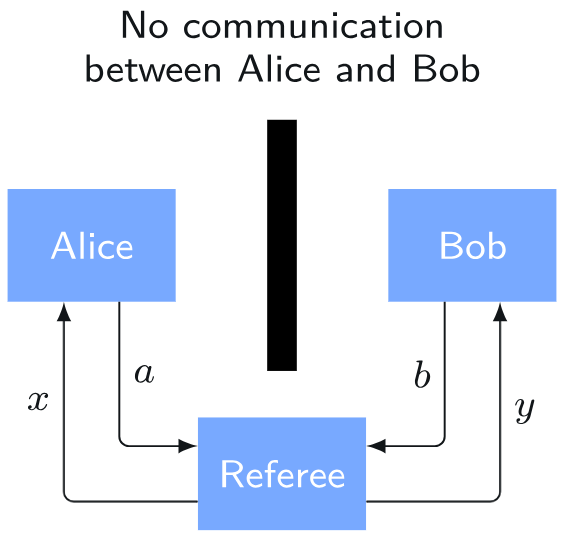

# Qiskit Implementation

In [5]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np

backend = AerSimulator()
pm = generate_preset_pass_manager(backend = backend, optimization_level=3)

In [6]:
def create_chsh_circuit(x, y):
    """Builds Qiskit circuit for Alice & Bob's quantum strategy."""
    qc = QuantumCircuit(2, 2, name=f'CHSH_{x}{y}') # 2 qubits, 2 classical bits

    # Implement the gates to create the Bell state |Φ+> = (|00> + |11>)/sqrt(2).
    qc.h(0), qc.cx(0,1) 

    qc.barrier()
    # Step 2a: Alice's measurement basis (X if x=1, Z if x=0)
    if x == 1:
        qc.h(0) # H for X-basis measurement

    # Step 2b: Bob's measurement basis
    if y == 0:
        qc.ry(-np.pi/4, 1)
    elif y == 1:
        qc.ry(np.pi/4, 1)
    
    qc.barrier()
    
    # Step 3: Measure
    qc.measure([0, 1], [0, 1]) # q0 to c0 (Alice), q1 to c1 (Bob) -> 'ba' format

    return qc

Quantum circuit for inputs x=1, y=1 (Check your Exercises 1 & 2 implementation):


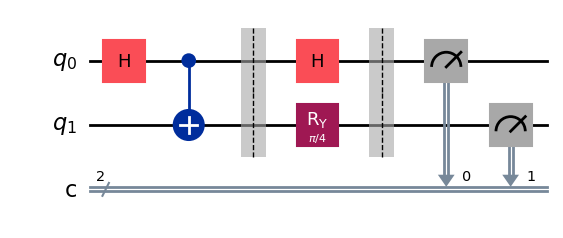

In [7]:
circuits = []
input_pairs = []
for x_in in [0, 1]:
    for y_in in [0, 1]:
        input_pairs.append((x_in, y_in))
        circuits.append(create_chsh_circuit(x_in, y_in))

print("Quantum circuit for inputs x=1, y=1 (Check your Exercises 1 & 2 implementation):")
if len(circuits) == 4:
    display(circuits[3].draw('mpl')) # (x,y) = (1,1)
else:
    print("Circuits not generated. Run previous cell after completing Exercises 1 & 2.")

Preparing circuits for the simulator...

--- Simulation Results (Counts) ---
Inputs (x=0, y=0):
  Outcomes (ba): {'00': 438, '01': 81, '10': 78, '11': 427}
Inputs (x=0, y=1):
  Outcomes (ba): {'00': 419, '01': 65, '10': 85, '11': 455}
Inputs (x=1, y=0):
  Outcomes (ba): {'00': 455, '01': 86, '10': 62, '11': 421}
Inputs (x=1, y=1):
  Outcomes (ba): {'00': 80, '01': 448, '10': 416, '11': 80}

Plotting results...


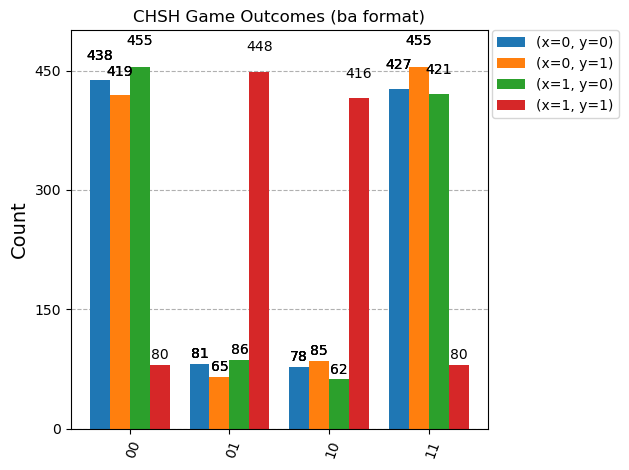

In [8]:
SHOTS = 1024

print("Preparing circuits for the simulator...")
isa_qc_chsh = pm.run(circuits)

sampler_chsh = Sampler(mode=backend) # SamplerV2
job_chsh = sampler_chsh.run(isa_qc_chsh, shots=SHOTS)
results_chsh = job_chsh.result()

counts_list = [results_chsh[i].data.c.get_counts() for i in range(len(circuits))]

print("\n--- Simulation Results (Counts) ---")
for i, (x, y) in enumerate(input_pairs):
    print(f"Inputs (x={x}, y={y}):")
    sorted_counts = dict(sorted(counts_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")

print("\nPlotting results...")
display(plot_histogram(counts_list,
                       legend=[f'(x={x}, y={y})' for x, y in input_pairs],
                       title='CHSH Game Outcomes (ba format)'))

In [9]:
win_probabilities = {}
print("--- Calculating Win Probabilities ---")

for i, (x, y) in enumerate(input_pairs):
    counts = counts_list[i]

    # Target (a XOR b) value for winning
    target_xor_result = x & y

    wins_for_this_case = 0

    # Calculate the total number of shots that satisfy the winning condition determined above. Check the 'target_xor_result'
    
    for outcome, count in counts.items():
        b = int(outcome[0])
        a = int(outcome[1])
        if a ^ b == target_xor_result:
            wins_for_this_case += count

    prob = wins_for_this_case / SHOTS if SHOTS > 0 else 0
    win_probabilities[(x, y)] = prob
    print(f"Inputs (x={x}, y={y}): Target (a XOR b) = {target_xor_result}. Win Probability = {prob:.4f}")

avg_win_prob = sum(win_probabilities.values()) / 4.0
P_win_quantum_theory = np.cos(np.pi / 8)**2  # ~0.8536
P_win_classical_limit = 0.75

print("\n--- Overall Performance ---")
print(f"Experimental Average Win Probability: {avg_win_prob:.4f}")
print(f"Theoretical Quantum Win Probability: {P_win_quantum_theory:.4f}")
print(f"Classical Limit Win Probability:     {P_win_classical_limit:.4f}")

if avg_win_prob > P_win_classical_limit + 0.01: # Allow for small simulation variance
    print(f"\nSuccess! Your result ({avg_win_prob:.4f}) clearly beats the classical 75% limit!")
    print(f"It's likely close to the theoretical quantum prediction of {P_win_quantum_theory:.4f}.")
elif avg_win_prob > P_win_classical_limit - 0.02 : # Could be noise or minor error
     print(f"\nClose, but no cigar? Your result ({avg_win_prob:.4f}) is around the classical limit ({P_win_classical_limit:.4f}).")
     print("Check your solutions for Exercises 1-4 carefully, especially the win counting logic in Ex 4.")
else:
    print(f"\nHmm, the result ({avg_win_prob:.4f}) is unexpectedly low, even below the classical limit.")
    print("There might be an error in Exercises 1-4. Please review your circuit and analysis code.")

--- Calculating Win Probabilities ---
Inputs (x=0, y=0): Target (a XOR b) = 0. Win Probability = 0.8447
Inputs (x=0, y=1): Target (a XOR b) = 0. Win Probability = 0.8535
Inputs (x=1, y=0): Target (a XOR b) = 0. Win Probability = 0.8555
Inputs (x=1, y=1): Target (a XOR b) = 1. Win Probability = 0.8438

--- Overall Performance ---
Experimental Average Win Probability: 0.8494
Theoretical Quantum Win Probability: 0.8536
Classical Limit Win Probability:     0.7500

Success! Your result (0.8494) clearly beats the classical 75% limit!
It's likely close to the theoretical quantum prediction of 0.8536.


# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/book" width="45" hspace="0px" vspace="0px"></a> References<a name="ref" />

\[1] https://quantum.cloud.ibm.com/docs/en/tutorials/chsh-inequality.

\[2] Qiskit Global Summer School 2025, https://github.com/qiskit-community/qgss-2025/tree/main?tab=readme-ov-file.